In [54]:
# Install missing package in the notebook environment (required to fix ModuleNotFoundError)
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from pyproj import Transformer
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
import rasterio
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import rasterio
from scipy.interpolate import splprep, splev, Rbf
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.interpolate import Rbf
from scipy.spatial import cKDTree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)



In [55]:
# --- Read anomaly data ---
df_anom = pd.read_parquet("df_illgraben_anomaly_scores.parquet", engine='fastparquet')
# --- Read coordinates ---
coords = pd.read_csv(
    "coords.txt",
    sep="|",
    comment="#",
    header=None,
    engine="python"
)

col_names = [
    "Network","Station","Location","Channel","Latitude","Longitude","Elevation",
    "Depth","Azimuth","Dip","SensorDescription","Scale","ScaleFreq",
    "ScaleUnits","SampleRate","StartTime","EndTime"
]
coords.columns = col_names
coords = coords.iloc[1:]  # drop first row if header repetition

# Clean numeric columns
coords["Latitude"] = pd.to_numeric(coords["Latitude"], errors="coerce")
coords["Longitude"] = pd.to_numeric(coords["Longitude"], errors="coerce")
coords["Elevation"] = pd.to_numeric(coords["Elevation"], errors="coerce")

# Keep latest record per station
coords = (
    coords.sort_values(["Station", "StartTime"], ascending=[True, False])
    .drop_duplicates("Station")
    .reset_index(drop=True)
)[["Station", "Latitude", "Longitude", "Elevation"]]


In [56]:
transformer = Transformer.from_crs("epsg:4326", "epsg:2056", always_xy=True)
coords["X_mn95"], coords["Y_mn95"] = transformer.transform(coords["Longitude"].values, coords["Latitude"].values)


In [57]:
# Merge coords
df_merged = df_anom.merge(coords, left_on="station", right_on="Station", how="left")
df_merged = df_merged.dropna(subset=["X_mn95", "Y_mn95"])


In [58]:
print(df_merged.columns)

Index(['station', 'time', 'anomaly_score', 'std', 'debris flow', 'Station',
       'Latitude', 'Longitude', 'Elevation', 'X_mn95', 'Y_mn95'],
      dtype='object')


In [59]:
# Round time to nearest minute
df_merged['time_minute'] = df_merged['time'].dt.round('1min')

# Aggregate by station and minute
df_minute = (df_merged
             .groupby(['station', 'time_minute'])
             .agg({
                 'anomaly_score': 'mean',
                 'debris flow': 'max',  # If any reading in that minute has debris flow
                 'X_mn95': 'first',
                 'Y_mn95': 'first',
                 'Elevation': 'first'
             })
             .reset_index())

print(f"  Original readings: {len(df_merged):,}")
print(f"  After 1-min aggregation: {len(df_minute):,}")
print(f"  Time range: {df_minute['time_minute'].min()} to {df_minute['time_minute'].max()}")


  Original readings: 8,274,482
  After 1-min aggregation: 6,896,017
  Time range: 2018-05-14 11:03:00 to 2022-08-28 21:22:00


In [60]:
# Filter to June 2020
df_june = df_minute[
    (df_minute['time_minute'] >= '2020-06-01') & 
    (df_minute['time_minute'] < '2020-07-01')
].copy()

# Drop ILL14 and ILL15
df_june = df_june[~df_june['station'].isin(['ILL14', 'ILL15'])]

print(f"  June 2020 data points: {len(df_june):,}")
print(f"  Stations: {sorted(df_june['station'].unique())}")

  June 2020 data points: 259,075
  Stations: ['ILL11', 'ILL12', 'ILL13', 'ILL16', 'ILL17', 'ILL18']


In [61]:
# Define debris flow events (max 15-minute gap allowed)
def identify_debris_flow_events(df, max_gap_minutes=15):
    """
    Identify continuous debris flow events with allowed gaps.
    """
    # Sort by time
    df = df.sort_values('time_minute').copy()
    
    # Find where debris flow = 1
    debris_times = df[df['debris flow'] == 1]['time_minute'].unique()
    debris_times = pd.Series(sorted(debris_times))
    
    if len(debris_times) == 0:
        df['event_id'] = 0
        return df, pd.DataFrame()
    
    # Calculate time gaps between consecutive debris flow minutes
    time_diffs = debris_times.diff()
    
    # Start new event when gap > max_gap_minutes
    event_breaks = time_diffs > pd.Timedelta(minutes=max_gap_minutes)
    event_ids = event_breaks.cumsum()
    
    # Create mapping from time to event_id
    time_to_event = pd.DataFrame({
        'time_minute': debris_times,
        'event_id': event_ids.values
    })
    
    # Merge back to main dataframe
    df = df.merge(time_to_event, on='time_minute', how='left')
    df['event_id'] = df['event_id'].fillna(0).astype(int)
    
    # Create event summary
    events_summary = (df[df['event_id'] > 0]
                     .groupby('event_id')
                     .agg({
                         'time_minute': ['min', 'max', 'count'],
                     }))
    events_summary.columns = ['start_time', 'end_time', 'n_minutes']
    events_summary['duration_min'] = (
        (events_summary['end_time'] - events_summary['start_time']).dt.total_seconds() / 60
    )
    
    return df, events_summary

df_june, events_summary = identify_debris_flow_events(df_june, max_gap_minutes=15)
print(f"\n  Debris flow events identified: {len(events_summary)}")
if len(events_summary) > 0:
    print(f"  Event durations (minutes): {events_summary['duration_min'].describe().to_dict()}")
    print("\n  Event details:")
    for event_id, row in events_summary.iterrows():
        print(f"    Event {event_id}: {row['start_time']} to {row['end_time']} "
              f"({row['duration_min']:.0f} min, {row['n_minutes']} readings)")


  Debris flow events identified: 7
  Event durations (minutes): {'count': 7.0, 'mean': 101.42857142857143, 'std': 76.1202056899856, 'min': 15.0, '25%': 39.0, '50%': 102.0, '75%': 147.5, 'max': 220.0}

  Event details:
    Event 1: 2020-06-07 07:10:00 to 2020-06-07 09:56:00 (166 min, 1002 readings)
    Event 2: 2020-06-08 13:38:00 to 2020-06-08 14:33:00 (55 min, 336 readings)
    Event 3: 2020-06-08 14:50:00 to 2020-06-08 15:13:00 (23 min, 144 readings)
    Event 4: 2020-06-08 15:44:00 to 2020-06-08 15:59:00 (15 min, 96 readings)
    Event 5: 2020-06-08 16:36:00 to 2020-06-08 18:45:00 (129 min, 780 readings)
    Event 6: 2020-06-17 03:18:00 to 2020-06-17 06:58:00 (220 min, 1326 readings)
    Event 7: 2020-06-29 04:29:00 to 2020-06-29 06:11:00 (102 min, 618 readings)


In [62]:
# Pivot to wide format
df_wide = df_june.pivot(index='time_minute', columns='station', values='anomaly_score')

# Check for missing data
missing_pct = (df_wide.isna().sum() / len(df_wide) * 100)
print(f"\n  Matrix shape: {df_wide.shape} (time points × stations)")
print(f"  Missing data percentage per station:")
for station in sorted(df_wide.columns):
    print(f"    {station}: {missing_pct[station]:.2f}%")

# Handle missing values with forward fill then backward fill
df_wide_filled = df_wide.fillna(method='ffill').fillna(method='bfill')

# If still any NaN (e.g., entire station missing), fill with 0
df_wide_filled = df_wide_filled.fillna(0)

print(f"  After filling: {df_wide_filled.isna().sum().sum()} missing values")

# Create debris flow indicator for time index
debris_flow_indicator = df_june.groupby('time_minute')['debris flow'].max()
debris_flow_indicator = debris_flow_indicator.reindex(df_wide_filled.index, fill_value=0)



  Matrix shape: (43200, 6) (time points × stations)
  Missing data percentage per station:
    ILL11: 0.23%
    ILL12: 0.06%
    ILL13: 0.00%
    ILL16: 0.00%
    ILL17: 0.00%
    ILL18: 0.00%
  After filling: 0 missing values


In [63]:
# Create correct side feature

# Get unique station coordinates
station_coords = (df_june
                 .groupby('station')
                 .agg({
                     'X_mn95': 'first',
                     'Y_mn95': 'first', 
                     'Elevation': 'first'
                 })
                 .reset_index())

# Define correct side (main torrent vs. wrong side)
#main_torrent_stations = ['ILL11', 'ILL12', 'ILL13', 'ILL16', 'ILL17', 'ILL18']
#station_coords['correct_side'] = station_coords['station'].isin(main_torrent_stations).astype(int)

# Sort by elevation (highest to lowest)
station_coords = station_coords.sort_values('Elevation', ascending=False).reset_index(drop=True)

print("\n  Station metadata:")
print(station_coords.to_string(index=False))


  Station metadata:
station       X_mn95       Y_mn95  Elevation
  ILL16 2.612365e+06 1.124225e+06     2041.6
  ILL17 2.612055e+06 1.124956e+06     1959.5
  ILL18 2.613613e+06 1.125145e+06     1449.0
  ILL12 2.614743e+06 1.126227e+06      913.5
  ILL13 2.614547e+06 1.127302e+06      735.1
  ILL11 2.615045e+06 1.128406e+06      665.2


### PCA

In [64]:
# Standardize the data (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_wide_filled)

# Fit PCA to determine number of components for 90% variance
pca_full = PCA()
pca_full.fit(X_scaled)

# Find number of components for 90% variance
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(cumsum_var >= 0.90) + 1

print(f"\n  Total stations: {df_wide_filled.shape[1]}")
print(f"  Components for 90% variance: {n_components}")
print(f"  Actual variance explained: {cumsum_var[n_components-1]:.2%}")


  Total stations: 6
  Components for 90% variance: 4
  Actual variance explained: 92.35%


In [65]:
# Fit PCA with selected number of components
pca = PCA(n_components=n_components)
pc_scores = pca.fit_transform(X_scaled)

print("\n  Variance explained by each component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"    PC{i+1}: {var:.2%}")



  Variance explained by each component:
    PC1: 54.54%
    PC2: 18.27%
    PC3: 11.30%
    PC4: 8.24%


In [66]:
# PC Scores: temporal patterns (n_timepoints, n_components)
pc_scores_df = pd.DataFrame(
    pc_scores,
    index=df_wide_filled.index,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

# PC Loadings: station weights (n_stations, n_components)
pc_loadings = pd.DataFrame(
    pca.components_.T,
    index=df_wide_filled.columns,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

print(f"\n  PC Scores shape: {pc_scores_df.shape}")
print(f"  PC Loadings shape: {pc_loadings.shape}")


  PC Scores shape: (43200, 4)
  PC Loadings shape: (6, 4)


In [67]:
# Verify reconstruction
X_reconstructed = pc_scores @ pca.components_ * scaler.scale_ + scaler.mean_
reconstruction_error = np.mean((X_scaled - (pc_scores @ pca.components_))**2)
print(f"  Reconstruction error (MSE): {reconstruction_error:.6f}")


  Reconstruction error (MSE): 0.076545



✓ Saved: pca_variance_explained.png


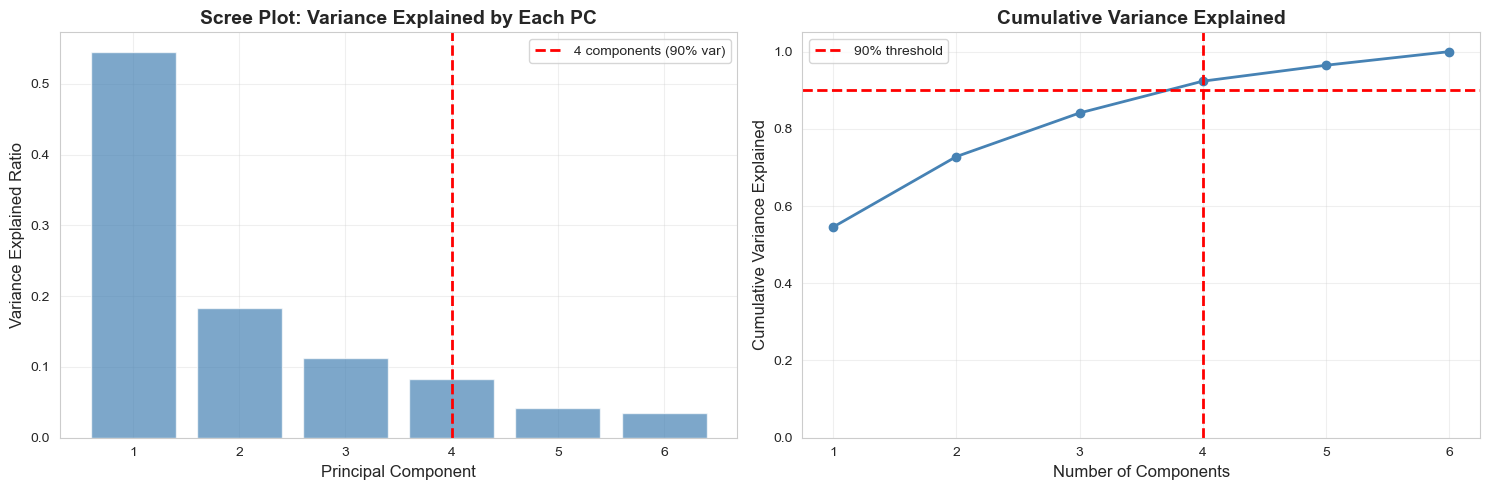

✓ Saved: pca_loadings_heatmap.png


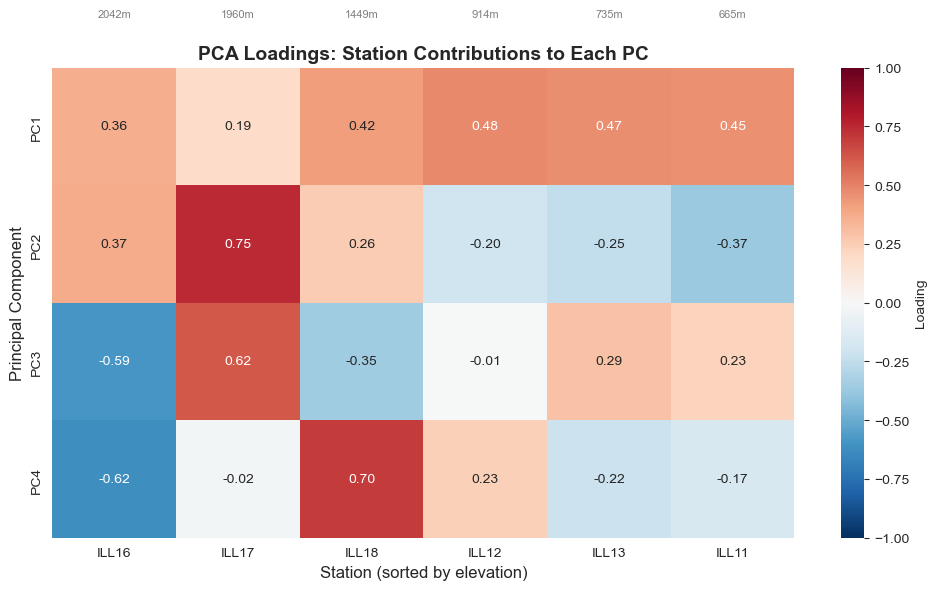

✓ Saved: pca_scores_timeseries_full.png


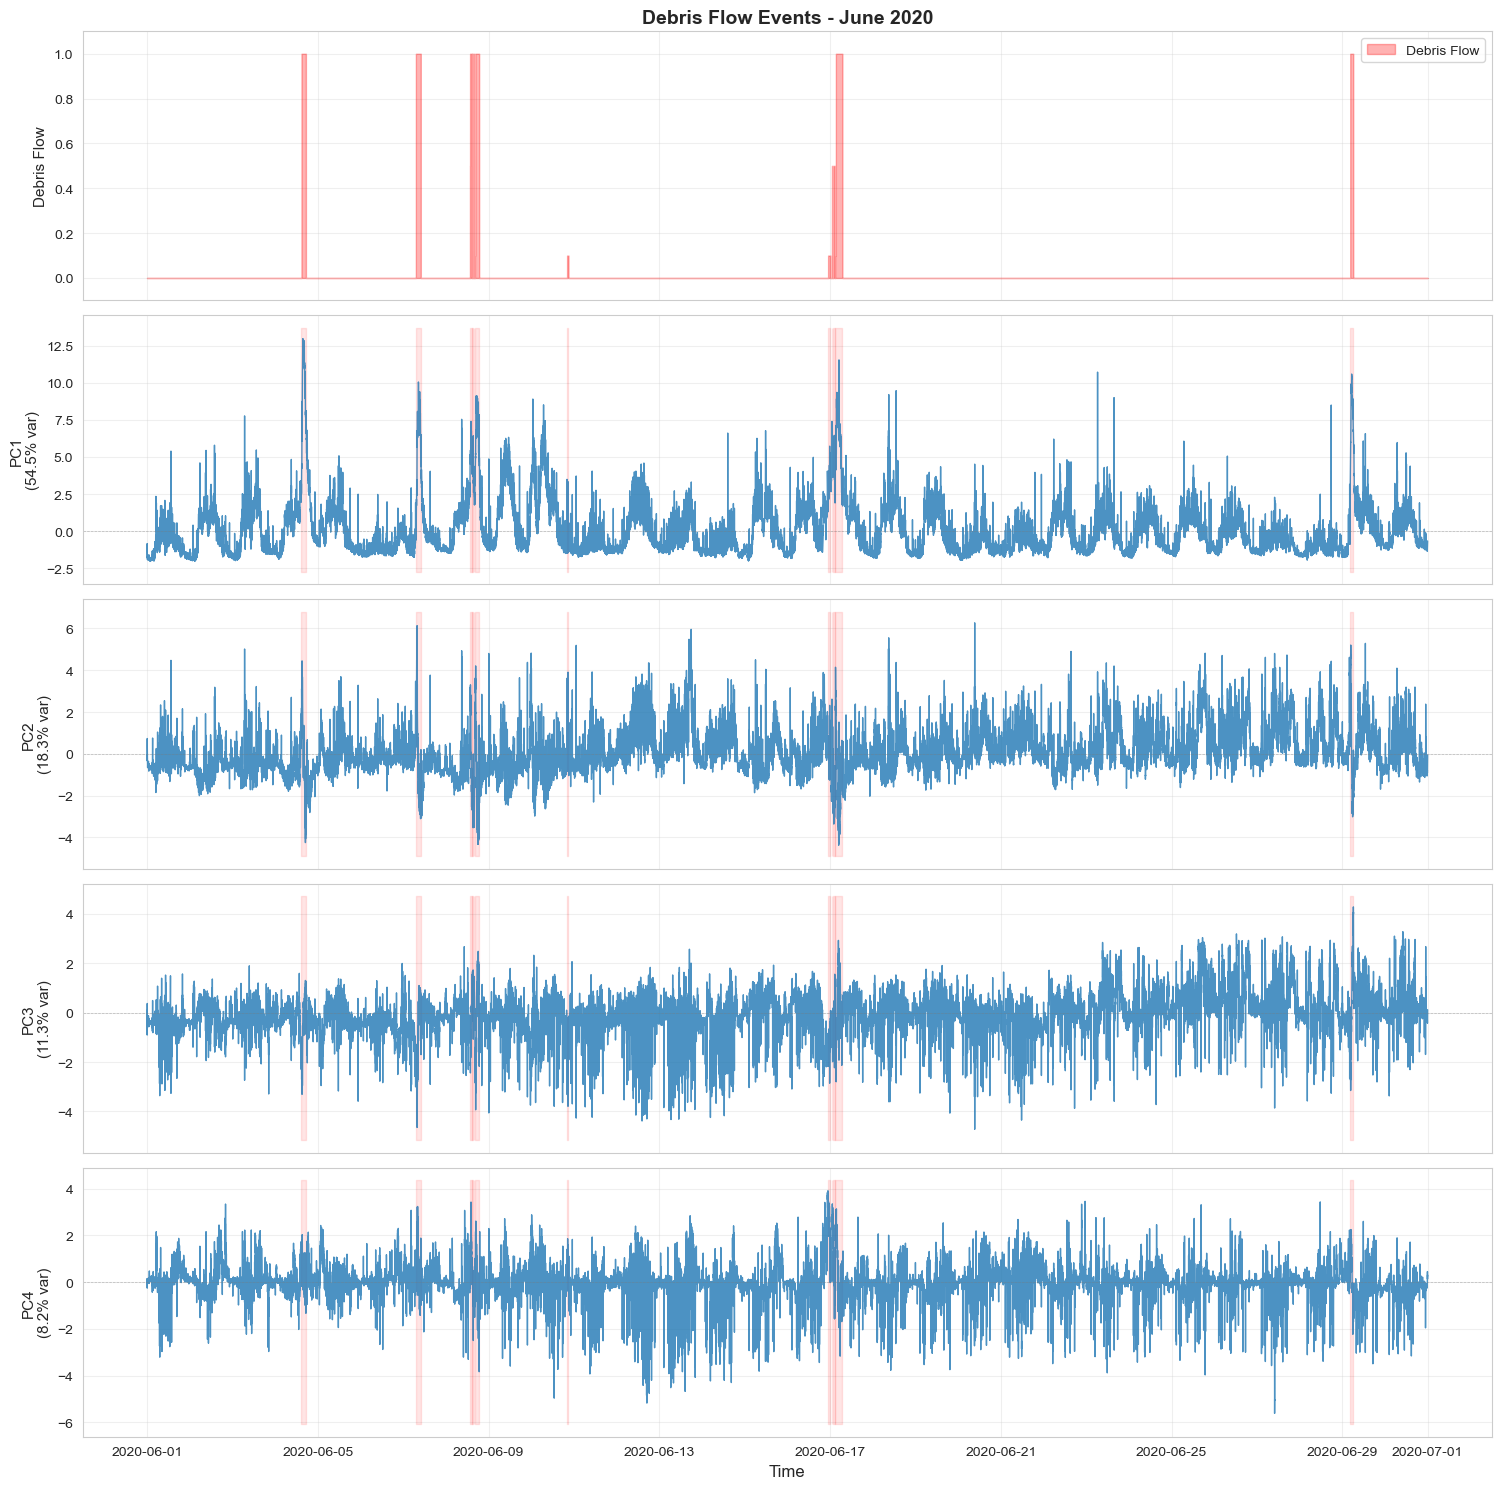

✓ Saved: pca_scores_event_1.png


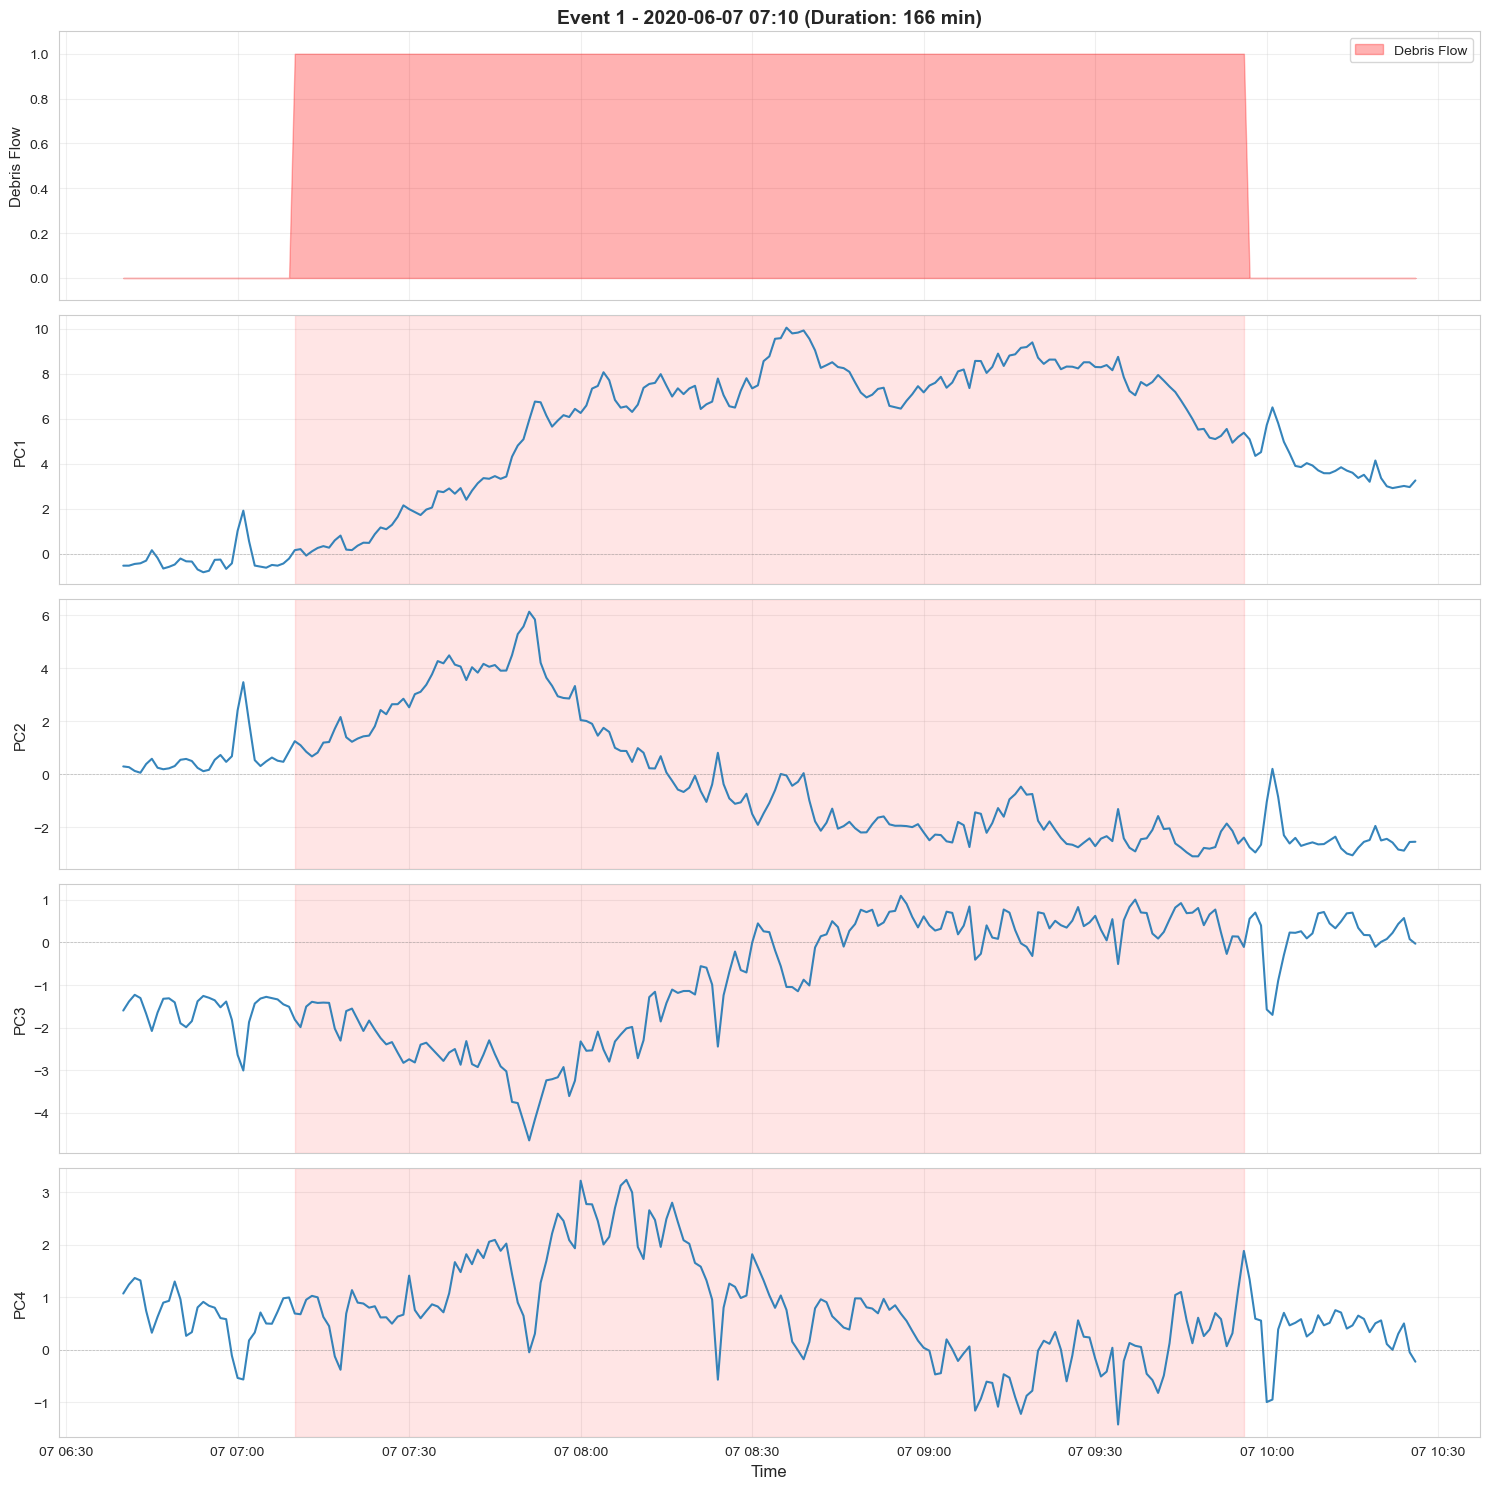

✓ Saved: pca_scores_event_2.png


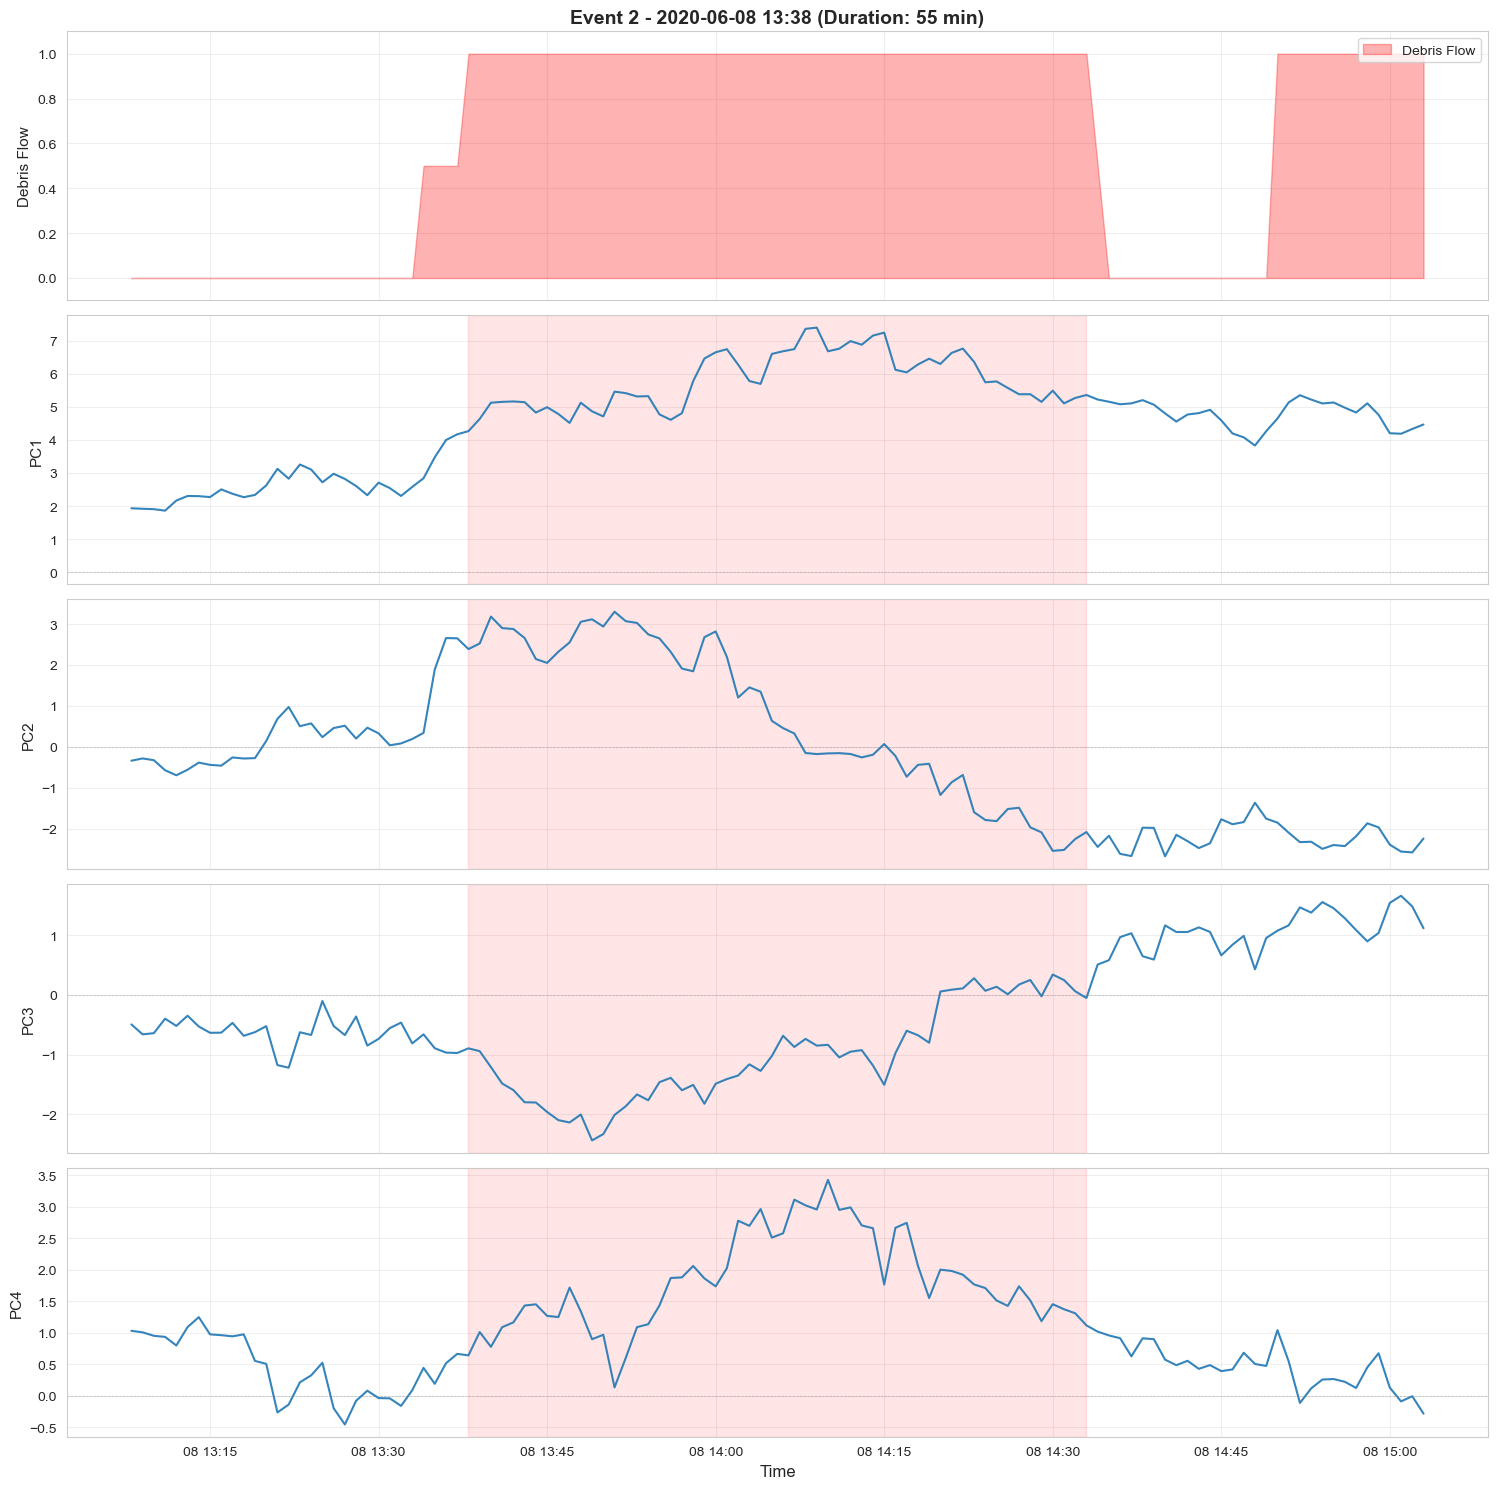

✓ Saved: pca_scores_event_3.png


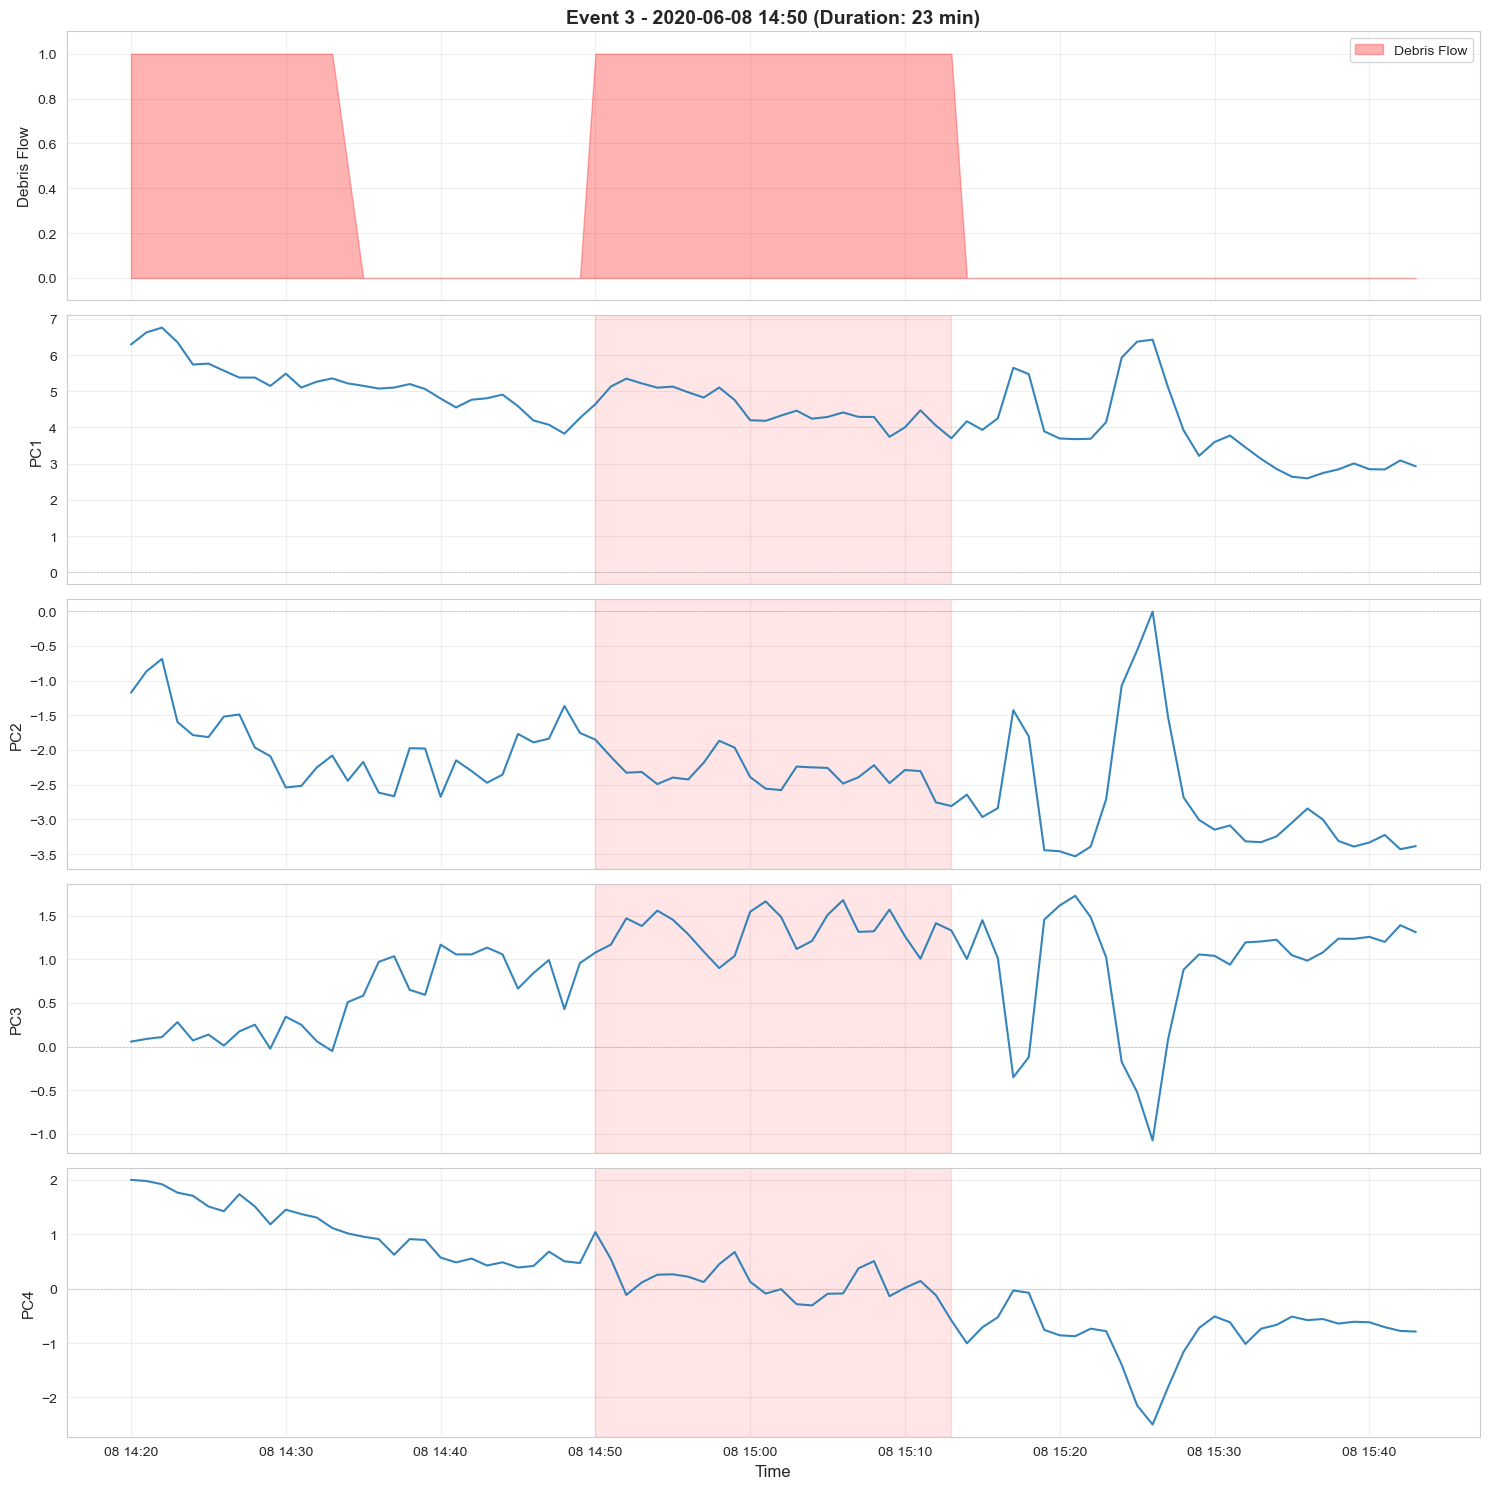

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# PCA Variance 

# Scree plot
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
            pca_full.explained_variance_ratio_, alpha=0.7, color='steelblue')
axes[0].axvline(n_components, color='red', linestyle='--', linewidth=2, 
                label=f'{n_components} components (90% var)')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Variance Explained Ratio', fontsize=12)
axes[0].set_title('Scree Plot: Variance Explained by Each PC', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumsum_var)+1), cumsum_var, 'o-', linewidth=2, color='steelblue')
axes[1].axhline(0.90, color='red', linestyle='--', linewidth=2, label='90% threshold')
axes[1].axvline(n_components, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Variance Explained', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('pca_variance_explained.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: pca_variance_explained.png")
plt.show()


# PC Loadings Heatmap

fig, ax = plt.subplots(figsize=(10, 6))

# Sort stations by elevation for better visualization
stations_by_elevation = station_coords.sort_values('Elevation', ascending=False)['station'].values
pc_loadings_sorted = pc_loadings.loc[stations_by_elevation]

sns.heatmap(pc_loadings_sorted.T, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, cbar_kws={'label': 'Loading'}, ax=ax, vmin=-1, vmax=1)
ax.set_xlabel('Station (sorted by elevation)', fontsize=12)
ax.set_ylabel('Principal Component', fontsize=12)
ax.set_title('PCA Loadings: Station Contributions to Each PC', fontsize=14, fontweight='bold')

# Add elevation annotations
for i, station in enumerate(stations_by_elevation):
    elev = station_coords[station_coords['station'] == station]['Elevation'].values[0]
    ax.text(i + 0.5, -0.5, f'{elev:.0f}m', 
            ha='center', va='top', fontsize=8, color='gray')

plt.tight_layout()
plt.savefig('pca_loadings_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: pca_loadings_heatmap.png")
plt.show()


# PC Scores Time Series (Full June 2020)

fig, axes = plt.subplots(n_components + 1, 1, figsize=(15, 3*(n_components+1)), sharex=True)

# Plot debris flow indicator
axes[0].fill_between(debris_flow_indicator.index, 0, debris_flow_indicator.values, 
                      alpha=0.3, color='red', label='Debris Flow')
axes[0].set_ylabel('Debris Flow', fontsize=11)
axes[0].set_ylim([-0.1, 1.1])
axes[0].legend(loc='upper right')
axes[0].set_title('Debris Flow Events - June 2020', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot each PC score
for i in range(n_components):
    axes[i+1].plot(pc_scores_df.index, pc_scores_df[f'PC{i+1}'], linewidth=1, alpha=0.8)
    axes[i+1].set_ylabel(f'PC{i+1}\n({pca.explained_variance_ratio_[i]:.1%} var)', fontsize=11)
    axes[i+1].axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    axes[i+1].grid(alpha=0.3)
    
    # Highlight debris flow periods
    axes[i+1].fill_between(debris_flow_indicator.index, 
                           axes[i+1].get_ylim()[0], 
                           axes[i+1].get_ylim()[1],
                           where=debris_flow_indicator.values > 0,
                           alpha=0.1, color='red')

axes[-1].set_xlabel('Time', fontsize=12)
plt.tight_layout()
plt.savefig('pca_scores_timeseries_full.png', dpi=300, bbox_inches='tight')
print("✓ Saved: pca_scores_timeseries_full.png")
plt.show()


# PC Scores During Debris Flow Events (Zoomed)

if len(events_summary) > 0:
    # Plot first 3 events (or fewer if less than 3)
    n_events_to_plot = min(3, len(events_summary))
    
    for event_num, (event_id, event_info) in enumerate(events_summary.head(n_events_to_plot).iterrows()):
        # Add buffer around event
        start_time = event_info['start_time'] - pd.Timedelta(minutes=30)
        end_time = event_info['end_time'] + pd.Timedelta(minutes=30)
        
        # Filter data
        mask = (pc_scores_df.index >= start_time) & (pc_scores_df.index <= end_time)
        event_data = pc_scores_df[mask]
        event_debris = debris_flow_indicator[mask]
        
        # Create plot
        fig, axes = plt.subplots(n_components + 1, 1, figsize=(15, 3*(n_components+1)), sharex=True)
        
        # Debris flow indicator
        axes[0].fill_between(event_debris.index, 0, event_debris.values, 
                            alpha=0.3, color='red', label='Debris Flow')
        axes[0].set_ylabel('Debris Flow', fontsize=11)
        axes[0].set_ylim([-0.1, 1.1])
        axes[0].legend(loc='upper right')
        axes[0].set_title(f'Event {event_id} - {event_info["start_time"].strftime("%Y-%m-%d %H:%M")} '
                         f'(Duration: {event_info["duration_min"]:.0f} min)', 
                         fontsize=14, fontweight='bold')
        axes[0].grid(alpha=0.3)
        
        # PC scores
        for i in range(n_components):
            axes[i+1].plot(event_data.index, event_data[f'PC{i+1}'], linewidth=1.5, alpha=0.9)
            axes[i+1].set_ylabel(f'PC{i+1}', fontsize=11)
            axes[i+1].axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
            axes[i+1].grid(alpha=0.3)
            
            # Highlight actual debris flow period
            axes[i+1].axvspan(event_info['start_time'], event_info['end_time'], 
                             alpha=0.1, color='red')
        
        axes[-1].set_xlabel('Time', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'pca_scores_event_{event_id}.png', dpi=300, bbox_inches='tight')
        print(f"✓ Saved: pca_scores_event_{event_id}.png")
        plt.show()

### Random Forest

In [ ]:
# Define train and test stations
train_stations = ['ILL11', 'ILL12', 'ILL16', 'ILL18', 'ILL17']
test_stations = ['ILL13']

print(f"\n  Train stations ({len(train_stations)}): {train_stations}")
print(f"  Test stations ({len(test_stations)}): {test_stations}")

# Verify all stations are accounted for
all_stations = sorted(station_coords['station'].unique())
assert set(train_stations + test_stations) == set(all_stations), "Station split mismatch!"

# Create train/test station metadata
train_coords = station_coords[station_coords['station'].isin(train_stations)].copy()
test_coords = station_coords[station_coords['station'].isin(test_stations)].copy()

print("\n  Train set:")
print(train_coords.to_string(index=False))
print("\n  Test set:")
print(test_coords.to_string(index=False))


  Train stations (4): ['ILL11', 'ILL12', 'ILL16', 'ILL18']
  Test stations (2): ['ILL13', 'ILL17']

  Train set:
station       X_mn95       Y_mn95  Elevation  distance_from_top
  ILL16 2.612365e+06 1.124225e+06     2041.6           0.000000
  ILL18 2.613613e+06 1.125145e+06     1449.0        2502.366561
  ILL12 2.614743e+06 1.126227e+06      913.5        4273.937577
  ILL11 2.615045e+06 1.128406e+06      665.2        6693.642703

  Test set:
station       X_mn95       Y_mn95  Elevation  distance_from_top
  ILL17 2.612055e+06 1.124956e+06     1959.5         836.954440
  ILL13 2.614547e+06 1.127302e+06      735.1        5390.040899


In [75]:
# Create channel centerline (using your provided function structure)
def create_channel_points_simple(station_coords, spacing=25):
    """Create interpolated points along channel."""
    # Sort stations by elevation (top to bottom)
    stations_sorted = station_coords.sort_values('Elevation', ascending=False).reset_index(drop=True)
    
    # Interpolate with spline
    tck, u = splprep(
        [stations_sorted['X_mn95'].values, 
         stations_sorted['Y_mn95'].values, 
         stations_sorted['Elevation'].values],
        s=0,
        k=min(3, len(stations_sorted)-1)
    )
    
    # Calculate path length
    u_samples = np.linspace(0, 1, 100)
    x_samples, y_samples, z_samples = splev(u_samples, tck)
    path_length = np.sum(np.sqrt(
        np.diff(x_samples)**2 + np.diff(y_samples)**2 + np.diff(z_samples)**2
    ))
    
    # Sample at specified spacing
    n_points = max(int(path_length / spacing), len(stations_sorted))
    u_fine = np.linspace(0, 1, n_points)
    X_channel, Y_channel, Z_channel = splev(u_fine, tck)
    
    # Calculate distances along channel
    distances = np.zeros(n_points)
    for i in range(1, n_points):
        distances[i] = distances[i-1] + np.sqrt(
            (X_channel[i] - X_channel[i-1])**2 + 
            (Y_channel[i] - Y_channel[i-1])**2 +
            (Z_channel[i] - Z_channel[i-1])**2
        )
    
    return pd.DataFrame({
        'point_id': range(n_points),
        'X': X_channel,
        'Y': Y_channel,
        'Z': Z_channel,
        'distance_from_top': distances
    })

# Create channel points
channel_points = create_channel_points_simple(station_coords, spacing=25)
print(f"\n  Created {len(channel_points)} channel points")
print(f"  Channel length: {channel_points['distance_from_top'].max():.0f}m")
# Prepare features for prediction
X_channel = channel_points[['X', 'Y', 'Z']].values


  Created 267 channel points
  Channel length: 6694m


In [83]:
#Map stations to distance along channel
station_to_distance = {}
for station in all_stations:
    station_coords_point = station_coords[station_coords['station'] == station][['X_mn95', 'Y_mn95']].values[0]
    # Find nearest channel point
    distances_to_channel = np.sqrt(
        (channel_points['X'] - station_coords_point[0])**2 +
        (channel_points['Y'] - station_coords_point[1])**2
    )
    nearest_idx = distances_to_channel.argmin()
    station_to_distance[station] = channel_points.loc[nearest_idx, 'distance_from_top']
    print(f"    {station}: {station_to_distance[station]:.0f}m from top")

# Add distance_from_top to station_coords (BEFORE creating subsets)
station_coords['distance_from_top'] = station_coords['station'].map(station_to_distance)

# create train/test subsets (AFTER adding the column)
train_coords = station_coords[station_coords['station'].isin(train_stations)].copy()
test_coords = station_coords[station_coords['station'].isin(test_stations)].copy()

print("\n  Train set:")
print(train_coords[['station', 'X_mn95', 'Y_mn95', 'Elevation', 'distance_from_top']].to_string(index=False))
print("\n  Test set:")
print(test_coords[['station', 'X_mn95', 'Y_mn95', 'Elevation', 'distance_from_top']].to_string(index=False))

# Extract features (just distance)
X_train = train_coords[['distance_from_top', 'X_mn95', 'Y_mn95', 'Elevation',]].values  # Shape: (4, 1)
X_test = test_coords[['distance_from_top', 'X_mn95', 'Y_mn95', 'Elevation',]].values    # Shape: (2, 1)

# Get loadings for train/test stations
y_train_loadings = pc_loadings.loc[train_stations].values  # (4 stations, n_components)
y_test_loadings = pc_loadings.loc[test_stations].values    # (2 stations, n_components)

print(f"\n  X_train shape: {X_train.shape} (stations × features)")
print(f"  y_train_loadings shape: {y_train_loadings.shape} (stations × PCs)")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test_loadings shape: {y_test_loadings.shape}")

    ILL11: 6694m from top
    ILL12: 4274m from top
    ILL13: 5390m from top
    ILL16: 0m from top
    ILL17: 837m from top
    ILL18: 2502m from top

  Train set:
station       X_mn95       Y_mn95  Elevation  distance_from_top
  ILL16 2.612365e+06 1.124225e+06     2041.6           0.000000
  ILL18 2.613613e+06 1.125145e+06     1449.0        2502.366561
  ILL12 2.614743e+06 1.126227e+06      913.5        4273.937577
  ILL11 2.615045e+06 1.128406e+06      665.2        6693.642703

  Test set:
station       X_mn95       Y_mn95  Elevation  distance_from_top
  ILL17 2.612055e+06 1.124956e+06     1959.5         836.954440
  ILL13 2.614547e+06 1.127302e+06      735.1        5390.040899

  X_train shape: (4, 4) (stations × features)
  y_train_loadings shape: (4, 4) (stations × PCs)
  X_test shape: (2, 4)
  y_test_loadings shape: (2, 4)


In [84]:
# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5]
}


In [85]:
# Store models and results
rf_models = {}
train_scores = {}
feature_importances = {}

for pc_idx in range(n_components):
    pc_name = f'PC{pc_idx + 1}'
    print(f"\n  Training model for {pc_name}...")
    
    # Target: loadings for this PC across train stations
    y_train_pc = y_train_loadings[:, pc_idx]
    
    # Grid search with cross-validation
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(
        rf, 
        param_grid, 
        cv=3,  # 3-fold CV (limited by small sample size)
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train_pc)
    
    # Store best model
    best_model = grid_search.best_estimator_
    rf_models[pc_name] = best_model
    
    # Evaluate on train set
    y_train_pred = best_model.predict(X_train)
    train_mse = mean_squared_error(y_train_pc, y_train_pred)
    train_r2 = r2_score(y_train_pc, y_train_pred)
    
    train_scores[pc_name] = {
        'mse': train_mse,
        'rmse': np.sqrt(train_mse),
        'r2': train_r2
    }
    
    # Feature importance
    feature_importances[pc_name] = best_model.feature_importances_
    
    print(f"    Best params: {grid_search.best_params_}")
    print(f"    Train RMSE: {np.sqrt(train_mse):.4f}")
    print(f"    Train R²: {train_r2:.4f}")

# Compile feature importance
feature_names = ['distance_from_top', 'X_mn95', 'Y_mn95', 'Elevation']
fi_df = pd.DataFrame(feature_importances, index=feature_names).T

print("\n  Feature Importances (averaged across all PCs):")
print(fi_df.mean().sort_values(ascending=False))


  Training model for PC1...
    Best params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
    Train RMSE: 0.0461
    Train R²: -0.0002

  Training model for PC2...
    Best params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
    Train RMSE: 0.0945
    Train R²: 0.9062

  Training model for PC3...
    Best params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
    Train RMSE: 0.1051
    Train R²: 0.8888

  Training model for PC4...
    Best params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
    Train RMSE: 0.4871
    Train R²: -0.0019

  Feature Importances (averaged across all PCs):
Elevation            0.142145
X_mn95               0.122581
Y_mn95               0.121581
distance_from_top    0.113693
dtype: float64



✓ Saved: rf_feature_importance.png


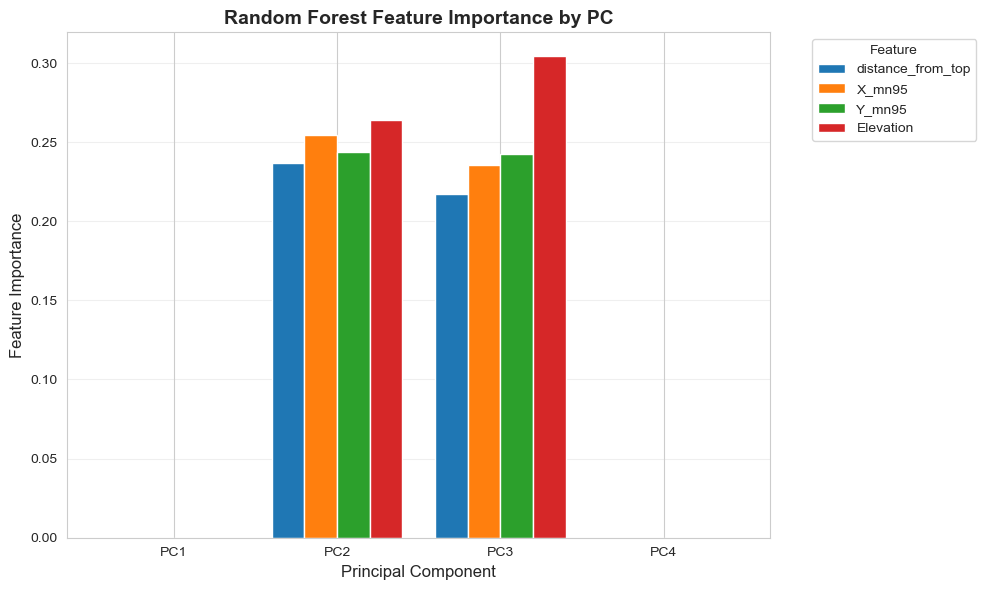

In [86]:
fig, ax = plt.subplots(figsize=(10, 6))

fi_df_plot = fi_df.copy()
fi_df_plot.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Feature Importance', fontsize=12)
ax.set_title('Random Forest Feature Importance by PC', fontsize=14, fontweight='bold')
ax.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: rf_feature_importance.png")
plt.show()

#### Predictions on Test Stations

In [87]:
# Predict loadings for each PC
predicted_test_loadings = np.zeros((len(test_stations), n_components))

for pc_idx in range(n_components):
    pc_name = f'PC{pc_idx + 1}'
    model = rf_models[pc_name]
    predicted_test_loadings[:, pc_idx] = model.predict(X_test)

# Create DataFrame for comparison
test_loadings_df = pd.DataFrame({
    'station': test_stations,
    **{f'PC{i+1}_actual': y_test_loadings[:, i] for i in range(n_components)},
    **{f'PC{i+1}_predicted': predicted_test_loadings[:, i] for i in range(n_components)}
})

print("\n  Predicted vs Actual Loadings for Test Stations:")
print(test_loadings_df.to_string(index=False))

# Compute loading prediction errors
loading_errors = {}
for pc_idx in range(n_components):
    pc_name = f'PC{pc_idx + 1}'
    actual = y_test_loadings[:, pc_idx]
    predicted = predicted_test_loadings[:, pc_idx]
    
    loading_errors[pc_name] = {
        'mse': mean_squared_error(actual, predicted),
        'mae': mean_absolute_error(actual, predicted),
        'r2': r2_score(actual, predicted)
    }
    
    print(f"\n  {pc_name} Loading Prediction:")
    print(f"    MAE: {loading_errors[pc_name]['mae']:.4f}")
    print(f"    RMSE: {np.sqrt(loading_errors[pc_name]['mse']):.4f}")
    print(f"    R²: {loading_errors[pc_name]['r2']:.4f}")



  Predicted vs Actual Loadings for Test Stations:
station  PC1_actual  PC2_actual  PC3_actual  PC4_actual  PC1_predicted  PC2_predicted  PC3_predicted  PC4_predicted
  ILL13    0.468604   -0.246766    0.292719   -0.215639       0.429312      -0.279187       0.102595       0.058379
  ILL17    0.192816    0.746517    0.623086   -0.024331       0.429312       0.283500      -0.429607       0.058379

  PC1 Loading Prediction:
    MAE: 0.1379
    RMSE: 0.1695
    R²: -0.5113

  PC2 Loading Prediction:
    MAE: 0.2477
    RMSE: 0.3282
    R²: 0.5633

  PC3 Loading Prediction:
    MAE: 0.6214
    RMSE: 0.7564
    R²: -19.9690

  PC4 Loading Prediction:
    MAE: 0.1784
    RMSE: 0.2024
    R²: -3.4770


#### Reconstruct Anomaly Scores for Test Stations

In [88]:
# Reconstruct using predicted loadings
# scores (n_timepoints, n_components) @ loadings (n_components, n_stations).T
test_reconstructed_scaled = pc_scores @ predicted_test_loadings.T  # (n_timepoints, 2)

# Un-standardize: X = X_scaled * std + mean
test_means = scaler.mean_[[all_stations.index(s) for s in test_stations]]
test_stds = scaler.scale_[[all_stations.index(s) for s in test_stations]]

test_reconstructed = test_reconstructed_scaled * test_stds + test_means

# Get actual test station anomaly scores
test_actual = df_wide_filled[test_stations].values

# Create DataFrames for analysis
test_reconstruction_df = pd.DataFrame({
    'time': df_wide_filled.index,
    'debris_flow': debris_flow_indicator.values
})

for i, station in enumerate(test_stations):
    test_reconstruction_df[f'{station}_actual'] = test_actual[:, i]
    test_reconstruction_df[f'{station}_predicted'] = test_reconstructed[:, i]
    test_reconstruction_df[f'{station}_error'] = test_actual[:, i] - test_reconstructed[:, i]

print(f"\n  Reconstructed {len(test_reconstruction_df)} time points")


  Reconstructed 43200 time points


In [89]:
if len(events_summary) > 0:
    debris_mask = test_reconstruction_df['debris_flow'] == 1
    
    print("\nTest Station Reconstruction Metrics (Debris Flow Times Only):")
    for station in test_stations:
        actual = test_reconstruction_df.loc[debris_mask, f'{station}_actual'].values
        predicted = test_reconstruction_df.loc[debris_mask, f'{station}_predicted'].values
        
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        
        print(f"\n  {station}:")
        print(f"    RMSE: {rmse:.4f}")
        print(f"    MAE:  {mae:.4f}")
        print(f"    R²:   {r2:.4f}")


Test Station Reconstruction Metrics (Debris Flow Times Only):

  ILL13:
    RMSE: 0.0457
    MAE:  0.0371
    R²:   0.8553

  ILL17:
    RMSE: 0.1772
    MAE:  0.1653
    R²:   -3.4686


✓ Saved: test_station_loading_prediction.png


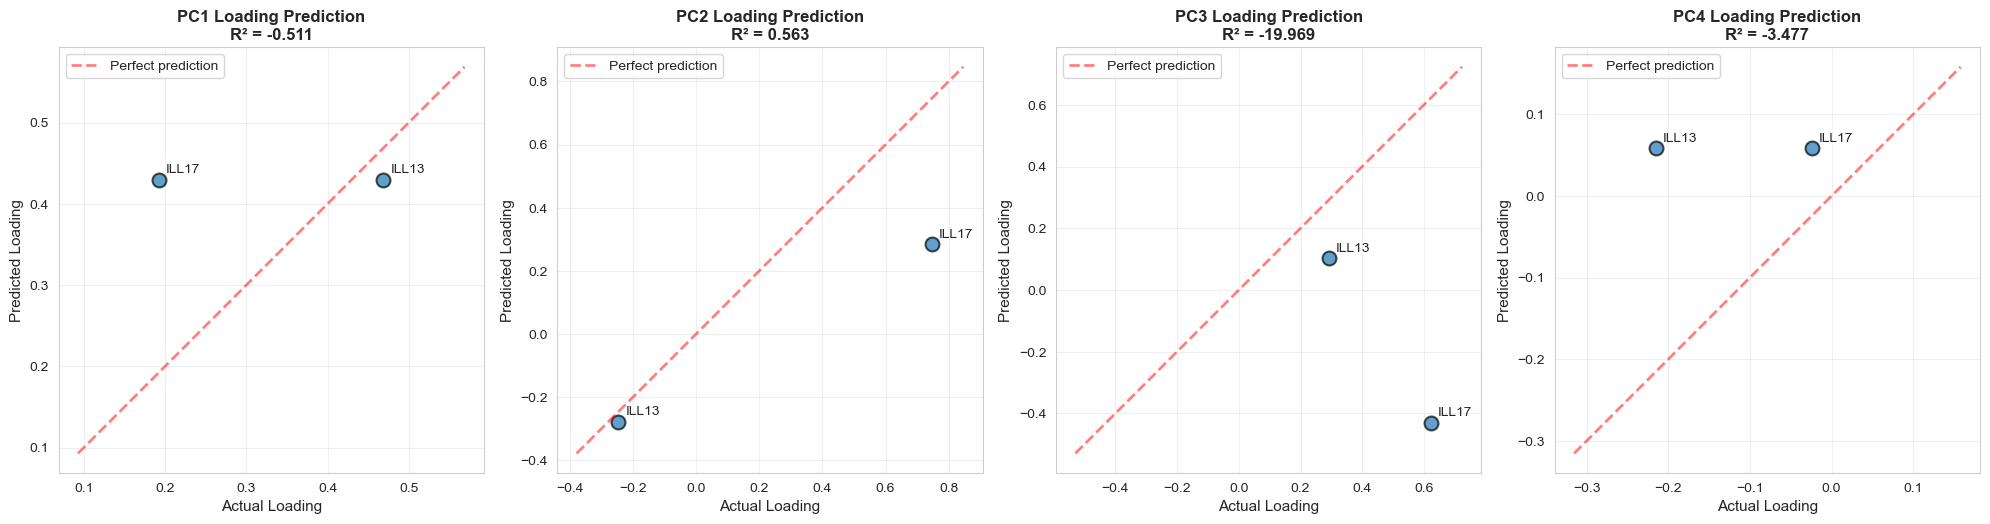

In [90]:
# Test stations loading predictions
fig, axes = plt.subplots(1, n_components, figsize=(5*n_components, 5))
if n_components == 1:
    axes = [axes]

for pc_idx in range(n_components):
    ax = axes[pc_idx]
    actual = y_test_loadings[:, pc_idx]
    predicted = predicted_test_loadings[:, pc_idx]
    
    ax.scatter(actual, predicted, s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
    
    # Add station labels
    for i, station in enumerate(test_stations):
        ax.annotate(station, (actual[i], predicted[i]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    # Add diagonal line
    lims = [min(actual.min(), predicted.min()) - 0.1,
            max(actual.max(), predicted.max()) + 0.1]
    ax.plot(lims, lims, 'r--', alpha=0.5, linewidth=2, label='Perfect prediction')
    
    ax.set_xlabel('Actual Loading', fontsize=11)
    ax.set_ylabel('Predicted Loading', fontsize=11)
    ax.set_title(f'PC{pc_idx+1} Loading Prediction\nR² = {loading_errors[f"PC{pc_idx+1}"]["r2"]:.3f}', 
                fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('test_station_loading_prediction.png', dpi=300, bbox_inches='tight')
print("✓ Saved: test_station_loading_prediction.png")
plt.show()

### Predict Channel Point Loadings

In [92]:
# Create channel centerline (using your provided function structure)
def create_channel_points_simple(station_coords, spacing=25):
    """Create interpolated points along channel."""
    # Sort stations by elevation (top to bottom)
    stations_sorted = station_coords.sort_values('Elevation', ascending=False).reset_index(drop=True)
    
    # Interpolate with spline
    tck, u = splprep(
        [stations_sorted['X_mn95'].values, 
         stations_sorted['Y_mn95'].values, 
         stations_sorted['Elevation'].values],
        s=0,
        k=min(3, len(stations_sorted)-1)
    )
    
    # Calculate path length
    u_samples = np.linspace(0, 1, 100)
    x_samples, y_samples, z_samples = splev(u_samples, tck)
    path_length = np.sum(np.sqrt(
        np.diff(x_samples)**2 + np.diff(y_samples)**2 + np.diff(z_samples)**2
    ))
    
    # Sample at specified spacing
    n_points = max(int(path_length / spacing), len(stations_sorted))
    u_fine = np.linspace(0, 1, n_points)
    X_channel, Y_channel, Z_channel = splev(u_fine, tck)
    
    # Calculate distances along channel
    distances = np.zeros(n_points)
    for i in range(1, n_points):
        distances[i] = distances[i-1] + np.sqrt(
            (X_channel[i] - X_channel[i-1])**2 + 
            (Y_channel[i] - Y_channel[i-1])**2 +
            (Z_channel[i] - Z_channel[i-1])**2
        )
    
    return pd.DataFrame({
        'point_id': range(n_points),
        'X': X_channel,
        'Y': Y_channel,
        'Z': Z_channel,
        'distance_from_top': distances
    })

# Create channel points
channel_points = create_channel_points_simple(station_coords, spacing=25)
print(f"\n  Created {len(channel_points)} channel points")
print(f"  Channel length: {channel_points['distance_from_top'].max():.0f}m")
# Prepare features for prediction
X_channel = channel_points[['distance_from_top', 'X', 'Y', 'Z']].values

# Predict loadings for all channel points
channel_loadings = np.zeros((len(channel_points), n_components))

for pc_idx in range(n_components):
    pc_name = f'PC{pc_idx + 1}'
    model = rf_models[pc_name]
    channel_loadings[:, pc_idx] = model.predict(X_channel)

print(f"\n  Predicted loadings shape: {channel_loadings.shape}")


  Created 267 channel points
  Channel length: 6694m

  Predicted loadings shape: (267, 4)


In [93]:
# Reconstruct: scores @ loadings.T
channel_reconstructed_scaled = pc_scores @ channel_loadings.T  # (n_timepoints, n_channel_points)

# Un-standardize (approximate using mean/std from all stations)
# Note: This is an approximation since channel points are interpolated
mean_anomaly = scaler.mean_.mean()
std_anomaly = scaler.scale_.mean()

channel_reconstructed = channel_reconstructed_scaled * std_anomaly + mean_anomaly

print(f"  Reconstructed anomaly scores shape: {channel_reconstructed.shape}")
print(f"  Value range: [{channel_reconstructed.min():.3f}, {channel_reconstructed.max():.3f}]")

# Create DataFrame for channel predictions
channel_predictions_df = pd.DataFrame(
    channel_reconstructed,
    index=df_wide_filled.index,
    columns=[f'point_{i}' for i in range(len(channel_points))]
)


  Reconstructed anomaly scores shape: (43200, 267)
  Value range: [0.325, 0.832]


In [94]:
# For each time point, find peak location
peak_tracking = pd.DataFrame({
    'time': df_wide_filled.index,
    'debris_flow': debris_flow_indicator.values
})

# Actual peaks (from actual station data)
peak_tracking['actual_peak_station'] = df_wide_filled.idxmax(axis=1)
peak_tracking['actual_peak_value'] = df_wide_filled.max(axis=1)

# Predicted peaks on channel
peak_channel_idx = np.argmax(channel_reconstructed, axis=1)
peak_tracking['predicted_peak_point_id'] = peak_channel_idx
peak_tracking['predicted_peak_distance'] = channel_points.loc[peak_channel_idx, 'distance_from_top'].values
peak_tracking['predicted_peak_value'] = channel_reconstructed[np.arange(len(channel_reconstructed)), peak_channel_idx]

# Map actual station peaks to distance along channel
station_to_distance = {}
for station in all_stations:
    station_coords_point = station_coords[station_coords['station'] == station][['X_mn95', 'Y_mn95']].values[0]
    # Find nearest channel point
    distances_to_channel = np.sqrt(
        (channel_points['X'] - station_coords_point[0])**2 +
        (channel_points['Y'] - station_coords_point[1])**2
    )
    nearest_idx = distances_to_channel.argmin()
    station_to_distance[station] = channel_points.loc[nearest_idx, 'distance_from_top']

peak_tracking['actual_peak_distance'] = peak_tracking['actual_peak_station'].map(station_to_distance)
print(f"\n  Tracked {len(peak_tracking)} time points")
print(f"  Station to distance mapping:")
for station, dist in sorted(station_to_distance.items(), key=lambda x: x[1]):
    print(f"    {station}: {dist:.0f}m from top")


  Tracked 43200 time points
  Station to distance mapping:
    ILL16: 0m from top
    ILL17: 837m from top
    ILL18: 2502m from top
    ILL12: 4274m from top
    ILL13: 5390m from top
    ILL11: 6694m from top


✓ Saved: test_station_reconstruction_full.png


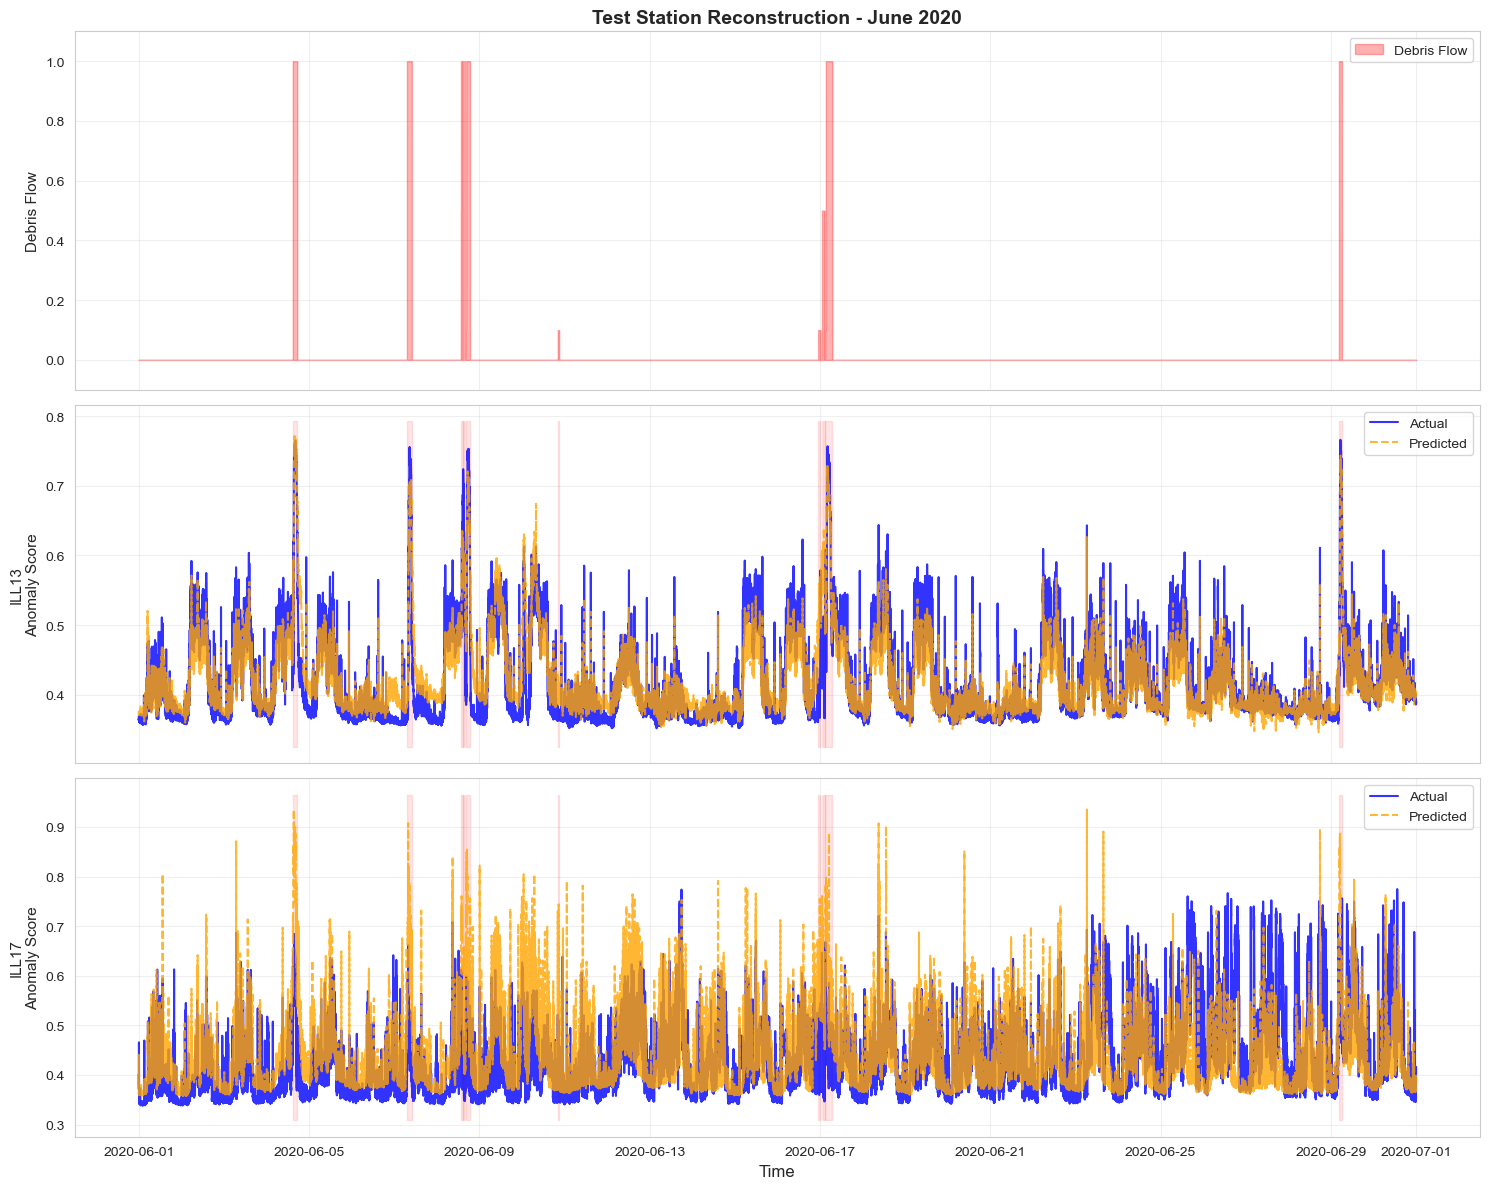

In [95]:
fig, axes = plt.subplots(len(test_stations) + 1, 1, 
                        figsize=(15, 4*(len(test_stations)+1)), sharex=True)

# Debris flow indicator
axes[0].fill_between(test_reconstruction_df['time'], 0, 
                     test_reconstruction_df['debris_flow'], 
                     alpha=0.3, color='red', label='Debris Flow')
axes[0].set_ylabel('Debris Flow', fontsize=11)
axes[0].set_ylim([-0.1, 1.1])
axes[0].legend(loc='upper right')
axes[0].set_title('Test Station Reconstruction - June 2020', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Each test station
for i, station in enumerate(test_stations):
    ax = axes[i+1]
    
    ax.plot(test_reconstruction_df['time'], 
           test_reconstruction_df[f'{station}_actual'],
           label='Actual', linewidth=1.5, alpha=0.8, color='blue')
    ax.plot(test_reconstruction_df['time'], 
           test_reconstruction_df[f'{station}_predicted'],
           label='Predicted', linewidth=1.5, alpha=0.8, color='orange', linestyle='--')
    
    ax.set_ylabel(f'{station}\nAnomaly Score', fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)
    
    # Highlight debris flow periods
    ax.fill_between(test_reconstruction_df['time'], 
                   ax.get_ylim()[0], ax.get_ylim()[1],
                   where=test_reconstruction_df['debris_flow'] > 0,
                   alpha=0.1, color='red')

axes[-1].set_xlabel('Time', fontsize=12)
plt.tight_layout()
plt.savefig('test_station_reconstruction_full.png', dpi=300, bbox_inches='tight')
print("✓ Saved: test_station_reconstruction_full.png")
plt.show()

✓ Saved: test_station_scatter_debris_flow.png


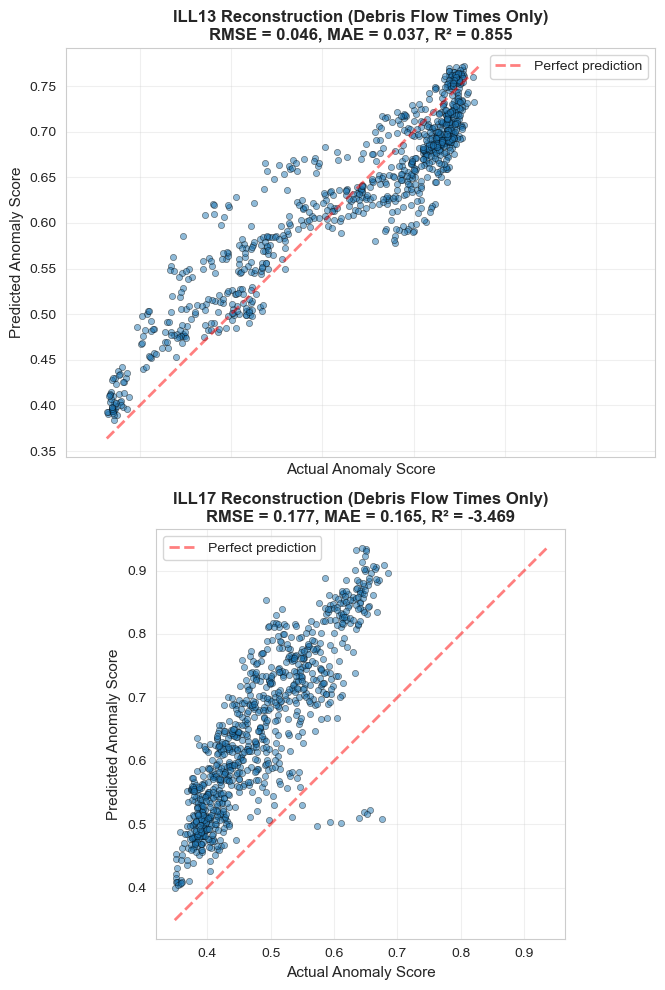

In [96]:
if len(events_summary) > 0:
    # Filter to debris flow times only
    debris_mask = test_reconstruction_df['debris_flow'] == 1
    debris_times = test_reconstruction_df[debris_mask]
    
    fig, axes = plt.subplots(len(test_stations), 1, 
                            figsize=(15, 5*len(test_stations)), sharex=True)
    if len(test_stations) == 1:
        axes = [axes]
    
    for i, station in enumerate(test_stations):
        ax = axes[i]
        
        actual = debris_times[f'{station}_actual'].values
        predicted = debris_times[f'{station}_predicted'].values
        
        ax.scatter(actual, predicted, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
        
        # Add diagonal line
        lims = [min(actual.min(), predicted.min()),
                max(actual.max(), predicted.max())]
        ax.plot(lims, lims, 'r--', alpha=0.5, linewidth=2, label='Perfect prediction')
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        
        ax.set_xlabel('Actual Anomaly Score', fontsize=11)
        ax.set_ylabel('Predicted Anomaly Score', fontsize=11)
        ax.set_title(f'{station} Reconstruction (Debris Flow Times Only)\n'
                    f'RMSE = {rmse:.3f}, MAE = {mae:.3f}, R² = {r2:.3f}',
                    fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
        ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('test_station_scatter_debris_flow.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: test_station_scatter_debris_flow.png")
    plt.show()

✓ Saved: channel_spatial_profiles_event1.png


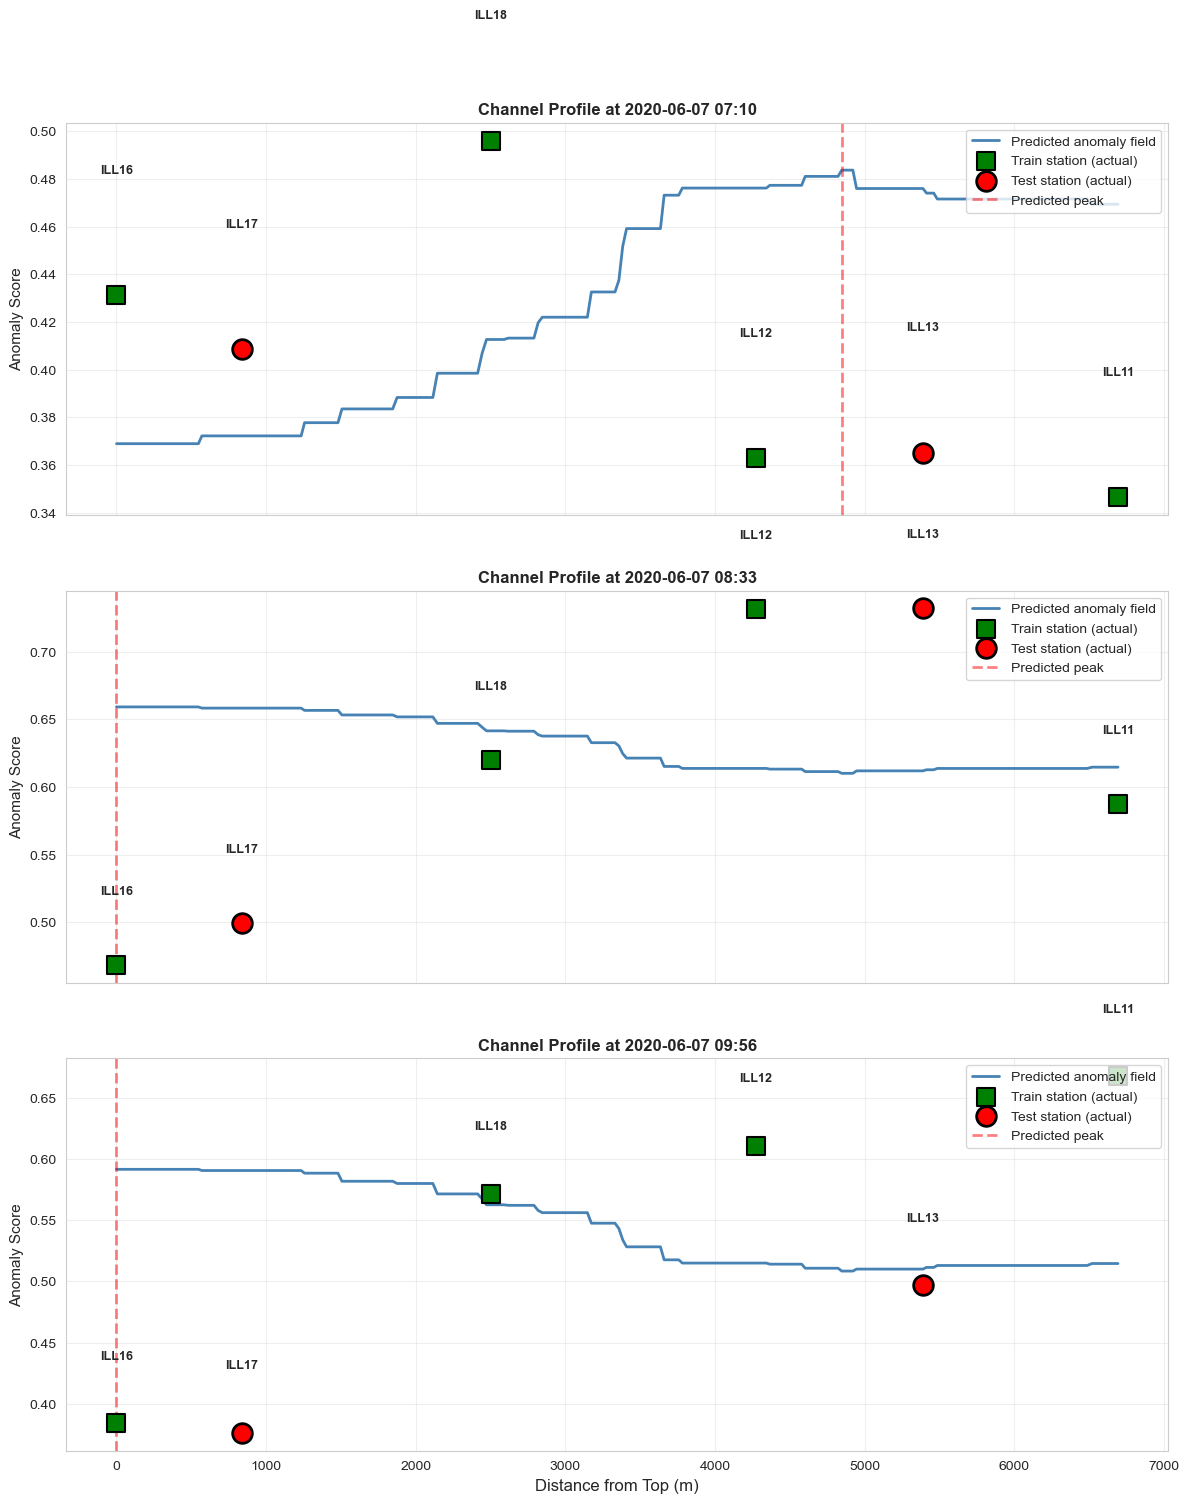

In [97]:
if len(events_summary) > 0:
    # Select 3 representative time points from first event
    event_1_times = test_reconstruction_df[
        (test_reconstruction_df['time'] >= events_summary.iloc[0]['start_time']) &
        (test_reconstruction_df['time'] <= events_summary.iloc[0]['end_time'])
    ]['time']
    
    if len(event_1_times) >= 3:
        snapshot_times = [
            event_1_times.iloc[0],  # Start
            event_1_times.iloc[len(event_1_times)//2],  # Middle
            event_1_times.iloc[-1]  # End
        ]
        
        fig, axes = plt.subplots(len(snapshot_times), 1, 
                                figsize=(12, 5*len(snapshot_times)), sharex=True)
        
        for i, snapshot_time in enumerate(snapshot_times):
            ax = axes[i]
            
            # Get time index
            time_idx = test_reconstruction_df[test_reconstruction_df['time'] == snapshot_time].index[0]
            
            # Get channel profile at this time
            channel_profile = channel_reconstructed[time_idx, :]
            
            # Plot channel profile
            ax.plot(channel_points['distance_from_top'], channel_profile,
                   linewidth=2, color='steelblue', label='Predicted anomaly field')
            
            # Overlay actual station measurements
            for station in all_stations:
                station_dist = station_to_distance[station]
                station_value = df_wide_filled.loc[snapshot_time, station]
                
                if station in test_stations:
                    ax.scatter(station_dist, station_value, s=200, 
                             color='red', marker='o', edgecolors='black', linewidth=2,
                             label='Test station (actual)' if station == test_stations[0] else '', 
                             zorder=5)
                else:
                    ax.scatter(station_dist, station_value, s=150, 
                             color='green', marker='s', edgecolors='black', linewidth=1.5,
                             label='Train station (actual)' if station == train_stations[0] else '',
                             zorder=5)
                
                ax.text(station_dist, station_value + 0.05, station,
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            # Mark predicted peak
            peak_dist = peak_tracking.loc[time_idx, 'predicted_peak_distance']
            peak_val = peak_tracking.loc[time_idx, 'predicted_peak_value']
            ax.axvline(peak_dist, color='red', linestyle='--', linewidth=2, 
                      alpha=0.5, label='Predicted peak')
            
            ax.set_ylabel('Anomaly Score', fontsize=11)
            ax.set_title(f'Channel Profile at {snapshot_time.strftime("%Y-%m-%d %H:%M")}',
                        fontsize=12, fontweight='bold')
            ax.legend(loc='upper right')
            ax.grid(alpha=0.3)
        
        axes[-1].set_xlabel('Distance from Top (m)', fontsize=12)
        plt.tight_layout()
        plt.savefig('channel_spatial_profiles_event1.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: channel_spatial_profiles_event1.png")
        plt.show()


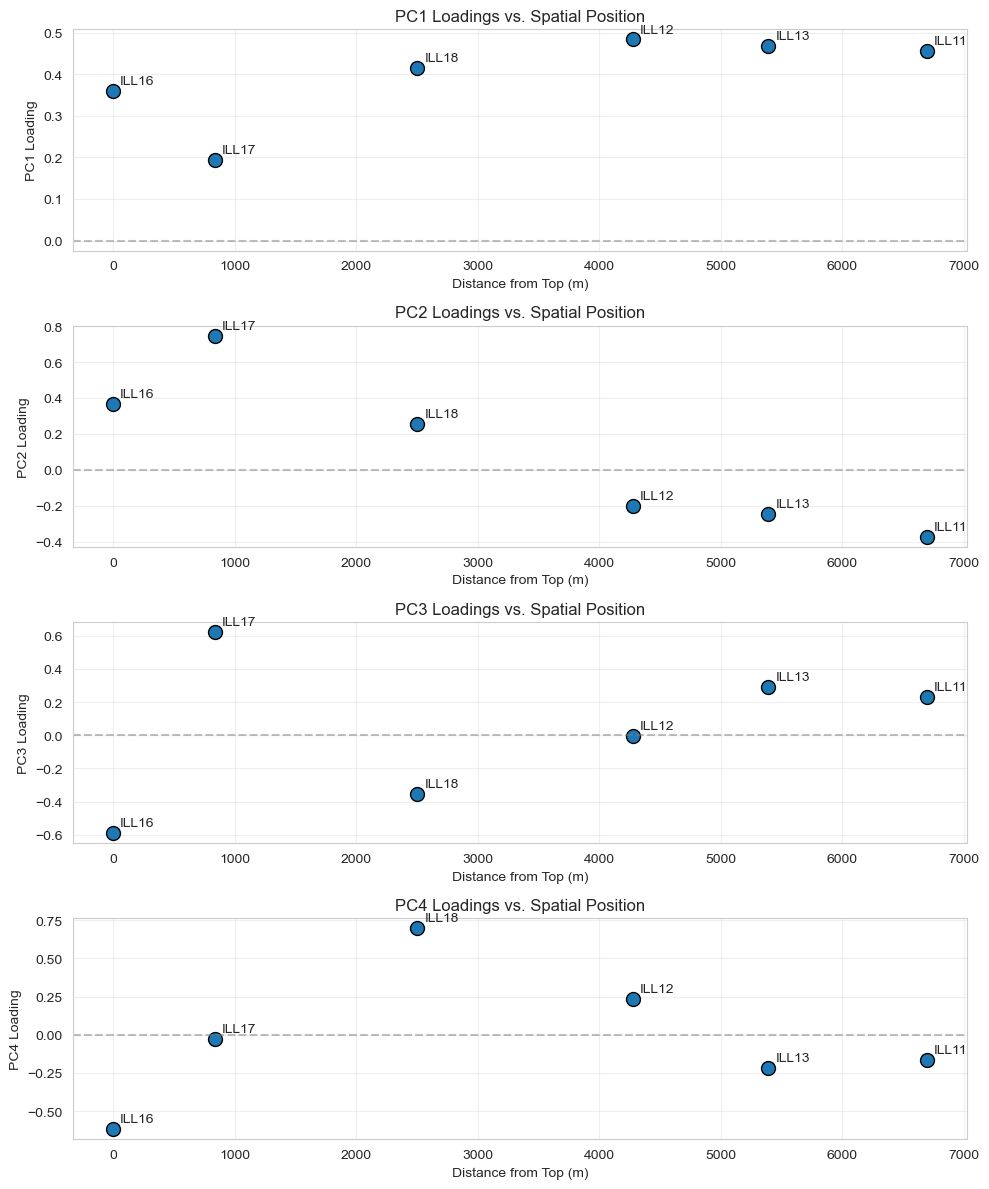

In [75]:
# Add this diagnostic
fig, axes = plt.subplots(n_components, 1, figsize=(10, 3*n_components))

for i in range(n_components):
    ax = axes[i] if n_components > 1 else axes
    
    # Get loadings for this PC
    loadings_pc = pc_loadings[f'PC{i+1}'].values
    stations = pc_loadings.index
    
    # Get distances
    distances = [station_to_distance[s] for s in stations]
    
    # Plot
    ax.scatter(distances, loadings_pc, s=100, edgecolors='black')
    for j, station in enumerate(stations):
        ax.annotate(station, (distances[j], loadings_pc[j]), 
                   xytext=(5, 5), textcoords='offset points')
    
    ax.set_xlabel('Distance from Top (m)')
    ax.set_ylabel(f'PC{i+1} Loading')
    ax.set_title(f'PC{i+1} Loadings vs. Spatial Position')
    ax.grid(alpha=0.3)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()